In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.metrics import MeanIoU
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from segmentation_models import get_preprocessing
import segmentation_models as sm

from tqdm import tqdm
import os
import numpy as np
import cv2

# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)



Segmentation Models: using `keras` framework.


In [2]:
parent_directory = "Dataset\images"

for i in os.listdir(parent_directory):
    print(f'{i} ---> {len(os.listdir(os.path.join(parent_directory, i)))}')

Astrocytoma ---> 529
Glioblastoma ---> 732
Gliomas ---> 1237
Meningioma ---> 640
Neurocytoma ---> 176


In [3]:
SIZE_X = 256
SIZE_Y = 256
IMAGES_FROM_CLASS = 300
TOTAL_CLASSES = 6

In [4]:
image_directory = r"Dataset\images";
mask_directory = r"Dataset\masks";

train_images = []
train_masks = []

class_labels = [i for i in os.listdir(image_directory)]

for class_name in tqdm(os.listdir(image_directory)):
    image_class_path = os.path.join(image_directory, class_name)
    mask_class_path = os.path.join(mask_directory, class_name)

    for filename in tqdm(os.listdir(image_class_path)[:IMAGES_FROM_CLASS]):
        image_path = os.path.join(image_class_path, filename)
        mask_path = os.path.join(mask_class_path, filename[:-4] + "_mask" + filename[-4:])
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue

        image = cv2.resize(image, (SIZE_X, SIZE_Y))
        image = image/255.

        mask = cv2.imread(mask_path, 0)
        if mask is None:
            print(f"Failed to read mask: {mask_path}")
            continue

        mask = cv2.resize(mask, (SIZE_X, SIZE_Y), interpolation = cv2.INTER_NEAREST)
        mask = mask / 255.
        mask[mask == 1] += class_labels.index(class_name)

        train_images.append(image)
        train_masks.append(mask)

        # print(np.unique(mask))


100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


In [5]:
image_directory = r"Dataset\images";
mask_directory = r"Dataset\masks";

validation_images = []
validation_masks = []

class_labels = [i for i in os.listdir(image_directory)]

for class_name in tqdm(os.listdir(image_directory)):
    image_class_path = os.path.join(image_directory, class_name)
    mask_class_path = os.path.join(mask_directory, class_name)

    if class_name == "Neurocytoma":
        IMAGES_FROM_CLASS = 75
    else:
        IMAGES_FROM_CLASS = 300

    for filename in tqdm(os.listdir(image_class_path)[IMAGES_FROM_CLASS:IMAGES_FROM_CLASS+100]):
        image_path = os.path.join(image_class_path, filename)
        mask_path = os.path.join(mask_class_path, filename[:-4] + "_mask" + filename[-4:])
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue

        image = cv2.resize(image, (SIZE_X, SIZE_Y))
        image = image/255.

        mask = cv2.imread(mask_path, 0)
        if mask is None:
            print(f"Failed to read mask: {mask_path}")
            continue

        mask = cv2.resize(mask, (SIZE_X, SIZE_Y), interpolation = cv2.INTER_NEAREST)
        mask = mask / 255.
        mask[mask == 1] += class_labels.index(class_name)

        validation_images.append(image)
        validation_masks.append(mask)

        # print(np.unique(mask))


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


In [6]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)

print(train_images.shape)
print(train_masks.shape)

(1376, 256, 256, 3)
(1376, 256, 256)


In [7]:
validation_images = np.array(validation_images)
validation_masks = np.array(validation_masks)

print(validation_images.shape)
print(validation_masks.shape)

(500, 256, 256, 3)
(500, 256, 256)


In [8]:
train_masks = np.expand_dims(train_masks, axis=3)
validation_masks = np.expand_dims(validation_masks, axis=3)

In [9]:
print(train_images.shape)
print(train_masks.shape)

print(validation_images.shape)
print(validation_masks.shape)

(1376, 256, 256, 3)
(1376, 256, 256, 1)
(500, 256, 256, 3)
(500, 256, 256, 1)


In [10]:
train_masks = to_categorical(train_masks, num_classes=TOTAL_CLASSES)
validation_masks = to_categorical(validation_masks, num_classes=TOTAL_CLASSES)

In [11]:
print(train_images.shape)
print(train_masks.shape)

print(validation_images.shape)
print(validation_masks.shape)

(1376, 256, 256, 3)
(1376, 256, 256, 6)
(500, 256, 256, 3)
(500, 256, 256, 6)


In [12]:
# Generate a permutation of indices
indices = np.arange(len(train_images))
np.random.shuffle(indices)

# Apply the permutation to both arrays in place
train_images[:] = train_images[indices]
train_masks[:] = train_masks[indices]

In [13]:
# Generate a permutation of indices
indices = np.arange(len(validation_images))
np.random.shuffle(indices)

# Apply the permutation to both arrays in place
validation_images[:] = validation_images[indices]
validation_masks[:] = validation_masks[indices]

In [14]:
np.unique(train_masks)
np.unique(validation_masks)

array([0., 1.], dtype=float32)

In [15]:
print(train_images.shape)
print(train_masks.shape)

print(validation_images.shape)
print(validation_masks.shape)

(1376, 256, 256, 3)
(1376, 256, 256, 6)
(500, 256, 256, 3)
(500, 256, 256, 6)


In [16]:

activation='softmax'
class_weights = [0.167, 0.764, 0.764, 0.764, 0.764, 1.304]
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [17]:
filepath = "checkpoints/improvement - {val_iou_score:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_iou_score', save_best_only= True, mode = 'max')

early_stopping = keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=10, min_delta=0.01, mode="max")

callbacks_list = [checkpoint, early_stopping]

In [18]:
BACKBONE = "inceptionresnetv2"
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
train_images = preprocess_input(train_images)
validation_images = preprocess_input(validation_images)

In [19]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=TOTAL_CLASSES, activation=activation)

In [20]:
model.compile(optim, total_loss, metrics=metrics)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [22]:
with tf.device('/cpu:0'):
    training = model.fit(train_images, train_masks, validation_data = (validation_images, validation_masks), batch_size=16, epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
86/86 [==============================] - 1439s 17s/step - loss: 1.0037 - iou_score: 0.0849 - f1-score: 0.1285 - val_loss: 1.0321 - val_iou_score: 0.0319 - val_f1-score: 0.0326
Epoch 2/50
86/86 [==============================] - 1414s 16s/step - loss: 0.9466 - iou_score: 0.3522 - f1-score: 0.4661 - val_loss: 0.9893 - val_iou_score: 0.0647 - val_f1-score: 0.0869
Epoch 3/50
86/86 [==============================] - 1406s 16s/step - loss: 0.8706 - iou_score: 0.5195 - f1-score: 0.6408 - val_loss: 0.9708 - val_iou_score: 0.1974 - val_f1-score: 0.2053
Epoch 4/50
86/86 [==============================] - 1405s 16s/step - loss: 0.6966 - iou_score: 0.6305 - f1-score: 0.7447 - val_loss: 0.9208 - val_iou_score: 0.2529 - val_f1-score: 0.2943
Epoch 5/50
86/86 [==============================] - 1403s 16s/step - loss: 0.5398 - iou_score: 0.6998 - f1-score: 0.8013 - val_loss: 0.9747 - val_iou_score: 0.1913 - val_f1-score: 0.1958
Epoch 6/50
86/86 [==============================] - 1404s 16s/ste

In [23]:
best_model = keras.models.load_model(r"checkpoints\improvement - 0.66.keras", compile=False)

In [24]:
test_image = cv2.imread(r"Dataset\images\Astrocytoma\Astrocytoma_T1_000.tif")
test_image = cv2.resize(image, (SIZE_X, SIZE_Y))

cv2.imshow("astrocytoma", test_image)
cv2.waitKey(0)
cv2.destroyAllWindows() 

test_image = image/255.


In [25]:
test_image.shape

(256, 256, 3)

In [26]:
test_image = np.expand_dims(test_image, 0)

In [27]:
test_image = preprocess_input(test_image)

In [28]:
predicted_mask = best_model.predict(test_image)

1/1 [==============================] - 9s 9s/step


In [29]:
predicted_mask.shape

(1, 256, 256, 6)

In [30]:
predicted_mask = np.squeeze(predicted_mask, axis=0)

In [31]:
predicted_mask.shape

(256, 256, 6)

In [ ]:
predicted_mask

In [32]:
predicted_mask = np.argmax(predicted_mask, axis = -1)

In [33]:
predicted_mask.shape


(256, 256)

In [34]:
np.unique(predicted_mask)

array([0], dtype=int64)

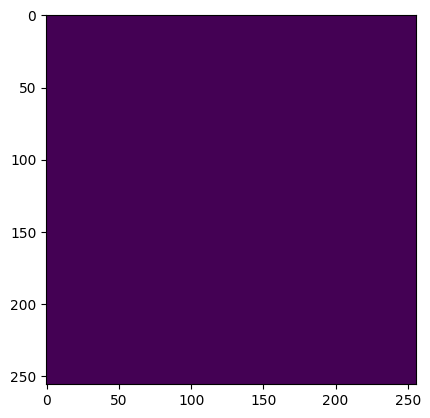

In [35]:
import matplotlib.pyplot as plt

plt.imshow(predicted_mask)
plt.show()